In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt

import iris.quickplot as qplt

import matplotlib.pyplot as plt
import cartopy.crs as ccrs  
import mo_pack
from matplotlib import ticker, cm
import iris.analysis.cartography
import aeolus
from aeolus.coord import volume_weights_cube, area_weights_cube, coord_delta_to_cube

In [2]:
warnings.filterwarnings("ignore")


# Import the climate and chemistry data

In [3]:
pcb_b = iris.load('../data_b/pcb_bnox_musc_7440_120_2.nc')

In [4]:
lfr = pcb_b.extract_cube('Stash code = 21115')
avtlfr = lfr.collapsed('t', iris.analysis.MEAN)

convect_d = pcb_b.extract_cube('DEEP CONVECTION INDICATOR')
convect_m = pcb_b.extract_cube('MID LEVEL CONVECTION INDICATOR')    
convect_s = pcb_b.extract_cube('SHALLOW CONVECTION INDICATOR')

# Some standard cube operations

In [5]:
from iris.util import broadcast_to_shape, guess_coord_axis, is_regular
from iris.analysis.cartography import wrap_lons

def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cube_min(cube):
    a=cube.collapsed('latitude', iris.analysis.MIN)
    b=a.collapsed('longitude', iris.analysis.MIN)
    return b.data

def cube_max(cube):
    a=cube.collapsed('latitude', iris.analysis.MAX)
    b=a.collapsed('longitude', iris.analysis.MAX)
    return b.data

def deltacube(cube1,cube2):
    cube3 = (cube1-cube2)
    return cube3


 
def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume

def _is_longitude_global(lon_points):
    """Return True if array of longitudes covers the whole sphere."""
    dx = np.diff(lon_points)[0]  # assume regular grid
    case_0_360 = ((lon_points[0] - dx) <= 0) and ((lon_points[-1] + dx) >= 360)
    case_pm180 = ((lon_points[0] - dx) <= -180) and ((lon_points[-1] + dx) >= 180)
    return case_0_360 or case_pm180

def roll_cube_pm180(cube_in):
    """
    Take a cube spanning 0...360 degrees in longitude and roll it to -180...180 degrees.

    Works with global model output, and in some cases for regional.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude and latitude coordinates.
    model: aeolus.model.Model, optional
        Model class with a relevant longitude coordinate name.

    Returns
    -------
    iris.cube.Cube

    See also
    --------
    aeolus.coord.roll_cube_0_360
    """
    cube = cube_in.copy()
    #coord_name = model.x  # get the name of the longitude coordinate
    xcoord = cube.coord('longitude')
    if (xcoord.points >= 0.0).all():
        assert is_regular(xcoord), "Operation is only valid for a regularly spaced coordinate."
        if _is_longitude_global(xcoord.points):
            # Shift data symmetrically only when dealing with global cubes
            cube.data = np.roll(cube.data, len(xcoord.points) // 2, axis=-1)

        if xcoord.has_bounds():
            bounds = wrap_lons(xcoord.bounds, -180, 360)  # + subtract
            bounds = bounds[bounds[:, 0].argsort(axis=0)]
        else:
            bounds = None
        cube.replace_coord(
            xcoord.copy(points=np.sort(wrap_lons(xcoord.points, -180, 360)), bounds=bounds)
        )
    else:
        # Nothing to do, the cube is already centered on 0 longitude
        # unless there is something wrong with longitude
        msg = f"Incorrect {coord_name} values: from {xcoord.points.min()} to {xcoord.points.max()}"
        assert ((xcoord.points >= -180.0) & (xcoord.points <= 180.0)).all(), msg
    return cube

def cuberoll_merid(cube_in):
    roll = roll_cube_pm180(cube_in)
    #roll_merid=meridional_mean(roll)
    return roll

# Distribution of convection: Figure 2 in Braam et al. (2022)

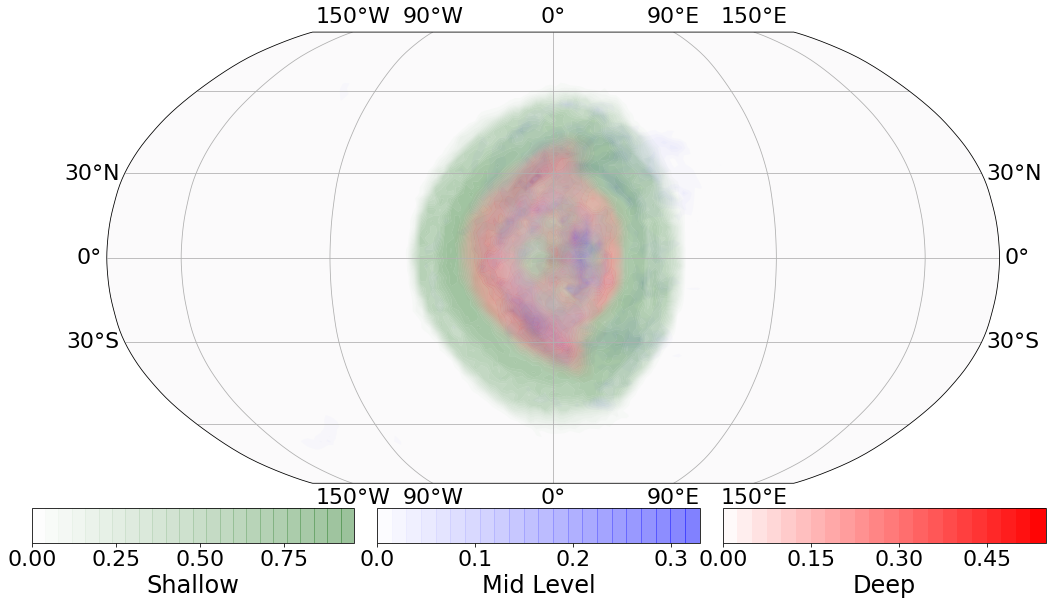

In [6]:
from matplotlib.colors import colorConverter
import matplotlib as mpl

plt.figure(figsize=(16,16))
ax = plt.axes(projection=ccrs.Robinson())
color1 = colorConverter.to_rgba('white')
color2 = colorConverter.to_rgba('black')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',[color1,'red'],256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,'blue'],256)
cmap3 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap3',[color1,'darkgreen'],256)

cmap2._init() # create the _lut array, with rgba values
cmap3._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas2 = np.linspace(0, 0.8, cmap2.N+3)
alphas3 = np.linspace(0, 0.8, cmap3.N+3)
cmap2._lut[:,-1] = alphas2
cmap3._lut[:,-1] = alphas3

a=iplt.contourf(convect_d[0,0,:,:], levels=25, alpha=1, linewidth=3, cmap=cmap1)
b=iplt.contourf(convect_m[0,0,:,:], levels=25, alpha=0.5, linewidth=3, cmap=cmap2)
c=iplt.contourf(convect_s[0,0,:,:], levels=25, alpha=0.4, linewidth=3, cmap=cmap3)

caax = plt.axes([0.66, 0.255, 0.28, 0.03]) 
ca = plt.colorbar(a, orientation='horizontal', cax=caax)
ca.set_label('Deep',size = 24)
ca.ax.tick_params(axis='x',labelsize=22)
tick_locator = ticker.MaxNLocator(nbins=4)
ca.locator = tick_locator
ca.update_ticks()
#ca.ax.set_xticklabels(['0.0','0.09','0.18','0.27','0.36','0.45','0.54','0.63'], fontsize=14)
cbax = plt.axes([0.36, 0.255, 0.28, 0.03]) 
cb = plt.colorbar(b, orientation='horizontal', cax=cbax)
cb.set_label('Mid Level',size = 24)
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
#plt.setp(cb.ax.get_xticklabels()[-1], visible=False)
cb.ax.tick_params(axis='x',labelsize=22)
#cb.ax.set_xticklabels(['0.0','0.045','0.09','0.135','0.18','0.225','0.27','0.315',''], fontsize=14)
ccax = plt.axes([0.06, 0.255, 0.28, 0.03]) 
cc = plt.colorbar(c, orientation='horizontal', cax=ccax)
cc.set_label('Shallow',size = 24)
tick_locator = ticker.MaxNLocator(nbins=4)
cc.locator = tick_locator
cc.update_ticks()
#plt.setp(cc.ax.get_xticklabels()[-1], visible=False)
cc.ax.tick_params(axis='x',labelsize=22)
#cc.ax.set_xticklabels(['0.0','0.12','0.24','0.36','0.48','0.60','0.72','0.84',''], fontsize=14)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = ticker.FixedLocator([-150, -90, 0, 90, 150])
gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xlabel_style = {'size': 22}
gl.ylabel_style = {'size': 22}
gl.rotate_labels = False


plt.show()

# The distribution of lightning flash rates scaled to annual: Figure 3 in Braam et al. (2022)

Mean, max, min: 0.0022802267 0.0 0.15637636
0.016098307
0.0864763


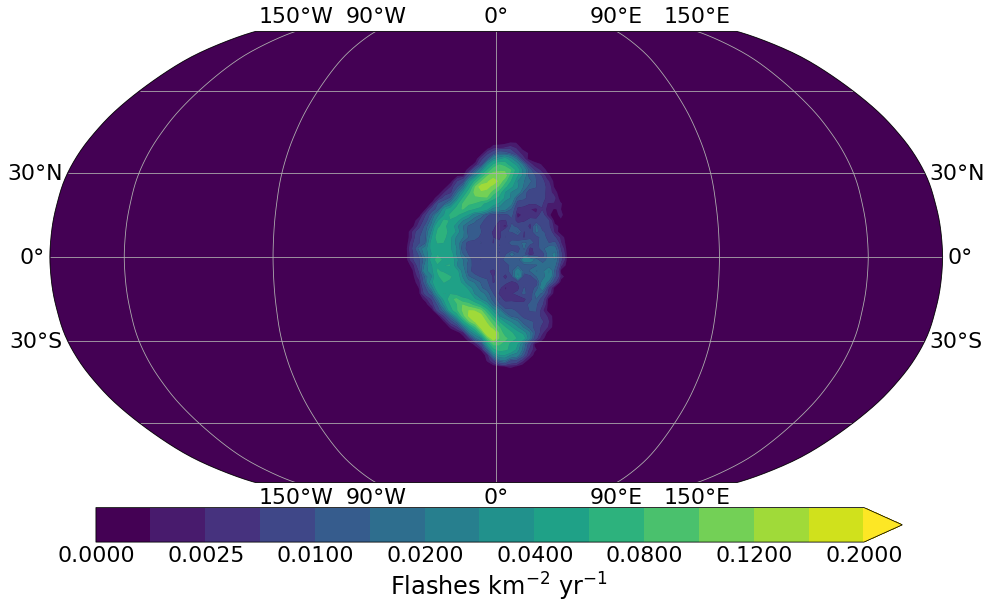

In [7]:
# linoxz = zonal_mean(meridional_mean(avtlinox3d))
print('Mean, max, min:', zonal_mean(meridional_mean(365*avtlfr[0,:,:])).data,
      cube_min(365*avtlfr[0,:,:]), cube_max(365*avtlfr[0,:,:]))

def latlonslice_mean(cube, lon_min, lon_max, lat_min, lat_max):
    slicedcube=cube.extract(iris.Constraint(longitude=lambda v: lon_min <= v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max))
    mean = meridional_mean(zonal_mean(slicedcube))
    return mean
print(latlonslice_mean(365*avtlfr[0,:,:], -30,25,-38,38).data)
print(latlonslice_mean(365*avtlfr[0,:,:],-4,4, 25,35).data)


levs = [0.0,0.001,0.0025,0.005,0.01,0.015,0.02,0.03,0.04,0.06,0.08,0.1,0.12,0.16,0.2]


fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection=ccrs.Robinson())
#plt.title("PCb", fontsize=24)
# Load a Cynthia Brewer palette. NICE
#brewer_cmap = mpl_cm.get_cmap('brewer_OrRd_09')
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(levs)))
cs2 = iplt.contourf(365*avtlfr[0,:,:], linewidth=0, levels=25, extend='max', cmap='viridis')
cs = iplt.contourf(365*avtlfr[0,:,:], linewidth=0, levels=levs, extend='max', colors=colors)
#iplt.contourf(8760*avtlfr[0,:,:], levels=25, linewidth=0, extend='both', cmap='viridis')
cbaxes = plt.axes([0.165, 0.255, 0.7, 0.03]) 
cbar = plt.colorbar(orientation='horizontal',cax = cbaxes)
# Label the colour bar and add ticks
cbar.set_label('Flashes km$^{-2}$ yr$^{-1}$', fontsize=24)
cbar.ax.tick_params(length=0, labelsize=22)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = ticker.FixedLocator([-150, -90, 0, 90, 150])
gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xlabel_style = {'size': 22}
gl.ylabel_style = {'size': 22}
gl.rotate_labels = False

plt.show()


